In [1]:
import tqdm

%load_ext autoreload
%autoreload 2
import sys
import os
print(os.environ['LD_LIBRARY_PATH'])
sys.executable

/usr/local/cuda-12.6/lib64:~/.virtualenvs/dopamine/lib/python3.10/site-packages/nvidia/cudnn//lib:/home/eop/.mujoco/mujoco210/bin:/usr/lib/nvidia


'/home/eop/code/CORL/venv/bin/python'

In [2]:
import os
import random
import uuid
from dataclasses import asdict, dataclass
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union

import d4rl
import gym
import numpy as np
import pyrallis
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from tqdm import tqdm, trange
import multiprocessing

multiprocessing.set_start_method('spawn', force=True)

No module named 'flow'
No module named 'carla'
pybullet build time: Nov 28 2023 23:45:17


In [3]:
env_name = 'maze2d-umaze-v1'
env = gym.make(env_name)
dataset = env.get_dataset()
torch.set_default_device('cuda')

load datafile: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 38.71it/s]


In [4]:
from algorithms.offline.knn import load_d4rl_trajectories

In [5]:
trajs, infos = load_d4rl_trajectories(env_name)
obs_shape = trajs[0]['observations'].shape[1]
action_shape=trajs[0]['actions'].shape[1]
obs_mean = infos['obs_mean']
obs_std = infos['obs_std']
print(obs_shape, action_shape)

load datafile: 100%|██████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 39.26it/s]


Processing trajectories:   0%|          | 0/1000000 [00:00<?, ?it/s]

4 2


In [6]:
infos

{'obs_mean': array([[ 1.9327888e+00,  2.3744664e+00,  2.0562936e-04, -1.0198415e-03]],
       dtype=float32),
 'obs_std': array([[0.89972275, 0.7093169 , 2.2128625 , 2.468174  ]], dtype=float32),
 'reward_mean': array([0.081254], dtype=float32),
 'reward_std': array([0.27322578], dtype=float32),
 'traj_lens': array([ 92,  53,  86, ..., 143, 110, 166])}

In [7]:
qdataset = dict()
next_state_distance = 3
qdataset["observations"] = np.concatenate([traj["observations"][:-next_state_distance] for traj in trajs], axis=0)
qdataset["actions"] = np.concatenate([traj["actions"][:-next_state_distance] for traj in trajs], axis=0)
qdataset["next_observations"] = np.concatenate([traj["observations"][next_state_distance:] for traj in trajs], axis=0)
qdataset["rewards"] = np.concatenate([traj["rewards"][:-next_state_distance] for traj in trajs], axis=0)

qdataset["observations"] = (qdataset["observations"] - obs_mean) / obs_std
qdataset["next_observations"] = (qdataset["next_observations"] - obs_mean) / obs_std
qdataset["rewards"] = (qdataset["rewards"] - qdataset["rewards"].mean()) / qdataset["rewards"].std()

In [8]:
class QDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset: Dict[str, np.ndarray]):
        self.dataset = dataset
        self.keys = list(dataset.keys())
        self.length = len(dataset[self.keys[0]])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        return {k: self.dataset[k][idx] for k in self.keys}

In [9]:
class Encoder(nn.Module):
    def __init__(self, obs_shape: int, hidden_dim: int, latent_dim: int):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(obs_shape, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, latent_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.ln1(x)
        x = F.relu(self.fc2(x))
        x = self.ln2(x)
        x = F.relu(self.fc3(x))
        x = self.ln3(x)
        return self.fc4(x)

class Identity(nn.Module):
    def forward(self, x):
        return x

class ForwardModel(nn.Module):
    def __init__(self, action_shape: int, hidden_dim: int, latent_dim: int):
        super(ForwardModel, self).__init__()
        self.fc1 = nn.Linear(latent_dim + action_shape, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, latent_dim)
        self.ln1 = nn.LayerNorm(hidden_dim)
        self.ln2 = nn.LayerNorm(hidden_dim)
        self.ln3 = nn.LayerNorm(hidden_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.ln1(x)
        x = F.relu(self.fc2(x))
        x = self.ln2(x)
        x = F.relu(self.fc3(x))
        x = self.ln3(x)
        return self.fc4(x)

class InvModel(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, action_shape: int):
        super(InvModel, self).__init__()
        self.fc1 = nn.Linear(latent_dim*2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, action_shape)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)
    
class RewardModel(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

use_encoder = True
hidden_dim = 256
latent_dim = 16 if use_encoder else obs_shape
encoder = Encoder(obs_shape=obs_shape, hidden_dim=hidden_dim, latent_dim=latent_dim) if use_encoder else Identity()
target_encoder = Encoder(obs_shape=obs_shape, hidden_dim=hidden_dim, latent_dim=latent_dim) if use_encoder else Identity()
model = ForwardModel(action_shape=action_shape, hidden_dim=hidden_dim, latent_dim=latent_dim)
inv_model = InvModel(latent_dim=latent_dim, hidden_dim=hidden_dim, action_shape=action_shape)
reward_model = RewardModel(latent_dim=latent_dim, hidden_dim=hidden_dim)

In [10]:
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR

batch_size = 256
target_ema = 0.95
epochs = 5
all_data = QDataset(qdataset)
train_size = int(0.8 * len(all_data))
dataset, val_set = torch.utils.data.random_split(all_data, [train_size, len(all_data) - train_size], generator=torch.Generator(device='cuda'))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
optimizer = AdamW(list(encoder.parameters()) + list(model.parameters()) + 
                  list(reward_model.parameters()) + list(inv_model.parameters()), lr=1e-3, weight_decay=1e-3)

def cosine_loss(z, z_next):
    return -F.cosine_similarity(z, z_next, dim=-1).mean()

def mse_loss(z, z_next):
    return F.mse_loss(z, z_next)

model_loss_fn = mse_loss

def train_step(batch):
    obs = batch['observations']
    act = batch['actions']
    next_obs = batch['next_observations']
    rews = batch['rewards'][:, None]
    
    z = encoder(obs)
    with torch.no_grad():
        z_next = target_encoder(next_obs)
    z_pred = model(torch.cat([z, act], dim=-1))
    reward_pred = reward_model(z)
    action_pred = inv_model(torch.cat([z, z_next], dim=-1))
    
    reward_loss = F.mse_loss(reward_pred, rews)
    model_loss = model_loss_fn(z_pred, z_next)
    action_loss = F.mse_loss(action_pred, act)
    loss = reward_loss + model_loss + action_loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Update target encoder with exponential moving average
    for param, target_param in zip(encoder.parameters(), target_encoder.parameters()):
        target_param.data = target_param.data * target_ema + param.data * (1.0 - target_ema)
    
    return loss.item(), reward_loss.item(), model_loss.item(), action_loss.item()

losses = []
reward_losses = []
model_losses = []
action_losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for batch in tqdm(dataloader):
        loss, reward_loss, model_loss, action_loss = train_step(batch)
        losses.append(loss)
        reward_losses.append(reward_loss)
        model_losses.append(model_loss)
        action_losses.append(action_loss)


Epoch 0


100%|███████████████████████████████████████████████████████████████████████████████| 3019/3019 [01:48<00:00, 27.76it/s]


Epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 3019/3019 [03:47<00:00, 13.30it/s]


Epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 3019/3019 [05:02<00:00,  9.98it/s]


Epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 3019/3019 [04:58<00:00, 10.11it/s]


Epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 3019/3019 [05:00<00:00, 10.05it/s]


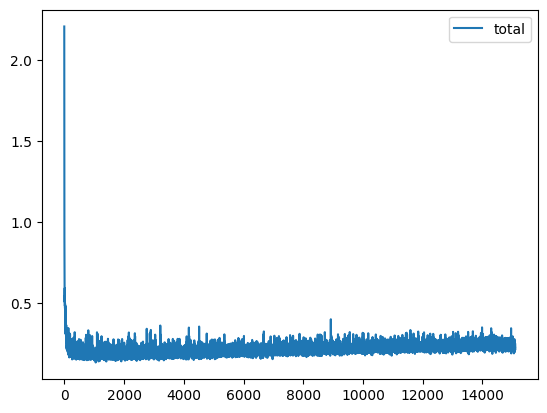

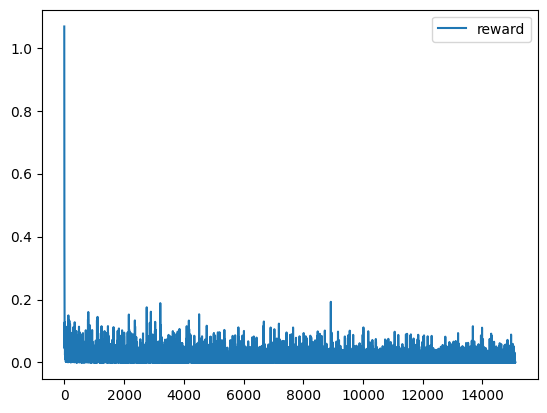

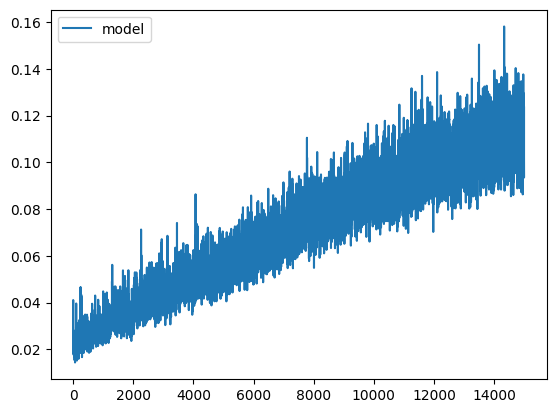

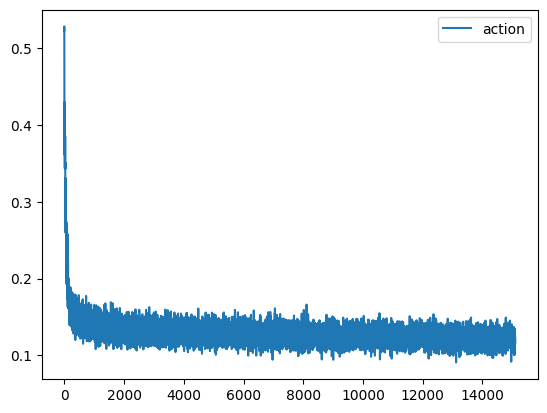

In [11]:
import matplotlib.pyplot as plt
plt.plot(losses, label='total')
plt.legend()
plt.show()

plt.plot(reward_losses, label='reward')
plt.legend()
plt.show()

plt.plot(model_losses[100:], label='model')
plt.legend()
plt.show()

plt.plot(action_losses, label='action')
plt.legend()
plt.show()

In [12]:
# validate that model is accurate

val_set_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))

model_loss_total = 0
model_loss_z_znext = 0
model_loss_random = 0
model_loss_shuffle = 0
with torch.no_grad():
    for batch in val_set_loader:
        z = encoder(batch['observations'])
        z_next = target_encoder(batch['next_observations'])
        z_pred = model(torch.cat([z, batch['actions']], dim=-1))
        model_loss_total += model_loss_fn(z_pred, z_next)
        model_loss_z_znext += model_loss_fn(z, z_next)
        model_loss_random += model_loss_fn(torch.randn_like(z), torch.randn_like(z_next))
        model_loss_shuffle += model_loss_fn(z[torch.randperm(len(z))], z_next)
print(
    f"Model loss: {model_loss_total / len(val_set_loader)}\n"
    f"Model loss (z, z_next): {model_loss_z_znext / len(val_set_loader)}\n"
    f"Model loss (random): {model_loss_random / len(val_set_loader)}\n"
    f"Model loss (shuffle): {model_loss_shuffle / len(val_set_loader)}"
)

Model loss: 0.11100799590349197
Model loss (z, z_next): 0.7039031386375427
Model loss (random): 1.9983711242675781
Model loss (shuffle): 20.024349212646484


In [13]:
from pynndescent import NNDescent
from dataclasses import dataclass
    
num_obs = np.sum(infos['traj_lens'])

obs_norm = np.zeros((num_obs, latent_dim), dtype=np.float32)
z_next = np.zeros((num_obs, latent_dim), dtype=np.float32)

returns = np.zeros(num_obs, dtype=np.float32)
actions = np.zeros((num_obs, trajs[0]['actions'].shape[1]), dtype=np.float32)


ind = 0
for traj in tqdm(trajs):
    indices = slice(ind, ind+traj['observations'].shape[0] - next_state_distance)
    obs = ((traj['observations'] - obs_mean) / obs_std)
    z = encoder(torch.tensor(obs, dtype=torch.float32)).detach().cpu().numpy()
    obs_norm[indices] = z[:-next_state_distance]
    z_next[indices] = z[1:-(next_state_distance-1)]
    returns[indices] = traj['returns'][:-next_state_distance]
    actions[indices] = traj['actions'][:-next_state_distance]
    ind += traj['observations'].shape[0] - next_state_distance

100%|███████████████████████████████████████████████████████████████████████████| 12459/12459 [00:08<00:00, 1387.71it/s]


In [14]:
index = NNDescent(obs_norm, metric='cosine' if model_loss_fn == cosine_loss else 'euclidean')

/home/eop/code/CORL/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [15]:
idx, dist = index.query(obs_norm[1243:1244], k=10)
idx.shape, idx

((1, 10),
 array([[  1243, 893257, 603644, 946989, 884178,  82718, 165079, 303782,
         720293, 429931]], dtype=int32))

In [16]:
from algorithms.offline.knn import wrap_env

eval_env = wrap_env(
    env=gym.make(env_name),
    state_mean=obs_mean,
    state_std=obs_std,
    reward_scale=1.0,
)
eval_episodes = 100
k=500


def eval():
    obs = eval_env.reset()
    done = False
    total_reward = 0.0
    while not done:
        z = encoder(torch.tensor(obs, dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()
        idxs, dists = index.query(z[0], k=k)
        neighbor_rets = returns[idxs]
        ranks = neighbor_rets * np.exp(-1 * dists)
        best_idx = idxs[0, np.argmax(ranks)]
        
        action = actions[best_idx]
        obs, reward, done, _ = eval_env.step(action)
        total_reward += reward
    return total_reward


eval_rets = [eval() for _ in trange(eval_episodes, desc="Evaluation", leave=False)]
np.mean(eval_rets), env.get_normalized_score(np.mean(eval_rets)) * 100.0

(89.03, 47.2284617056735)

In [17]:
def eval_inv_model():
    obs = eval_env.reset()
    done = False
    total_reward = 0.0
    while not done:
        z = encoder(torch.tensor(obs, dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()[0]
        idxs, dists = index.query(z, k=k)
        neighbor_rets = returns[idxs]
        ranks = neighbor_rets * np.exp(-1 * dists)
        best_idx = idxs[0, np.argmax(ranks)]

        action = inv_model(torch.tensor(np.concatenate([z, z_next[best_idx][None,:]], axis=-1), dtype=torch.float32).unsqueeze(0)).detach().cpu().numpy()
        obs, reward, done, _ = eval_env.step(action.squeeze())
        total_reward += reward
    return total_reward


eval_rets_inv = [eval_inv_model() for _ in trange(eval_episodes, desc="Evaluation", leave=False)]
np.mean(eval_rets_inv), env.get_normalized_score(np.mean(eval_rets_inv)) * 100.0

(61.76, 27.469023983769286)